<a href="https://colab.research.google.com/github/ckessler01/MVP_Analise_dados/blob/main/MVP_Analise_Dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MVP - Análise de Dados e Boas Práticas**

Cássio Eduardo Kessler

**1. Definição do problema**

Neste projeto será utilizado o conjunto de dados "Geração por usina em base horária", produzido e disponibilizado pelo Operador Nacional do Sistema Elétrico (ONS). O ONS é o órgão responsável pela coordenação e controle da operação das instalações de geração e transmissão de energia elétrica no Brasil. Este dataset apresenta o histórico da geração verificada por usina em base horária e pode ser baixado no seguinte endereço: https://dados.ons.org.br/dataset/geracao-usina-2




A tabela abaixo descreve os atributos do dataset:

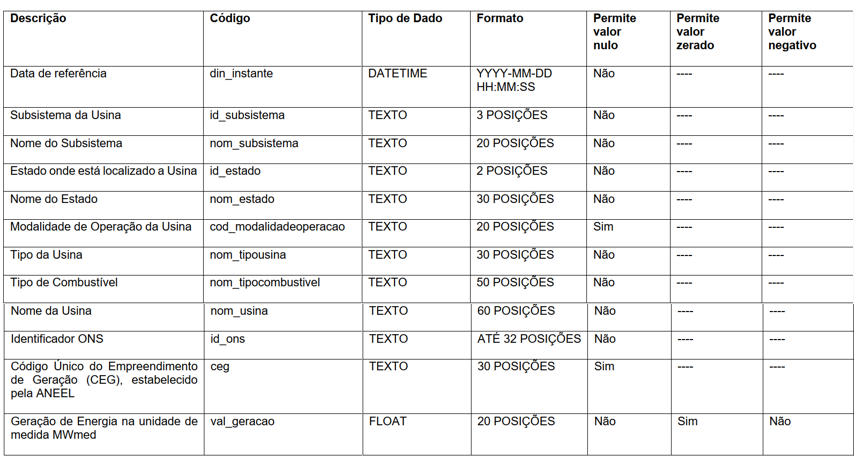





O objetivo do trabalho é analisar os dados de geração de energia no Brasil, avaliando a participação de cada fonte de energia na geração total.

Este tema tornou-se mais relevante recentemente devido ao aumento da participação das fontes eólica e solar, que não são despacháveis, ou seja, sua geração não pode ser comandada pelo Operador Nacional do Sistema (ONS), pois geram sempre que houver disponibilidade de vento e sol, respectivamente. Assim, nos momentos em que há menor disponibilidade destes recursos (principalmente no final da tarde), o ONS precisa comandar o despacho de outras fontes, como hidrelétricas e térmelétricas.

Desta forma, o presente trabalho visa explorar estes dados de geração e entender esta nova dinâmica da operação. Ressalto que, pelo menos em um primeiro momento, este projeto não busca resolver um problema de machine learning, por isso não serão realizadas tarefas relacionadas a isto, como por exemplo a separação do dataset em dados de treino e teste.

**2. Carga de Dados**

Os dados serão importados de um repositório no Github. Como o Github possui um limite no tamanho de arquivos, os dados foram divididos em diversos arquivos csv, que são carregados a partir de uma lista de URLs e posteriormente concatenados em um único dataframe para a realização da análise dos dados.

Como o volume de dados é expressivo e com o objetivo de não comprometer o tempo de execução do notebook na correção do trabalho, foram carregados apenas os dados de agosto de 2024, que são suficientes para as análises propostas neste projeto. Para avaliações mais detalhadas, poderão ser carregados futuramente os dados de um período mais longo.



In [1]:
#importação das bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno

In [2]:
# Carregamento dos dados

# Define a lista de URLs para os arquivos CSV no repositório do GitHub
urls = [
  'https://raw.githubusercontent.com/ckessler01/MVP_Analise_dados/main/GERACAO_USINA-2_2024_08_1.csv',
  'https://raw.githubusercontent.com/ckessler01/MVP_Analise_dados/main/GERACAO_USINA-2_2024_08_2.csv',
  'https://raw.githubusercontent.com/ckessler01/MVP_Analise_dados/main/GERACAO_USINA-2_2024_08_3.csv'
]

# Lista para armazenar os DataFrames carregados
df_list = []

# Loop para carregar cada arquivo CSV e armazenar no DataFrame
for url in urls:
    df = pd.read_csv(url, sep=';')
    df_list.append(df)

# Concatena todos os DataFrames em um único DataFrame
df_consolidado = pd.concat(df_list, ignore_index=True)

# Exibe informações do DataFrame consolidado (primeiras linhas e o total de
# linhas)
print(df_consolidado.head())
print(f"Total de linhas: {len(df_consolidado)}")

          din_instante id_subsistema nom_subsistema id_estado nom_estado  \
0  2024-08-01 00:00:00             N          NORTE        AC       ACRE   
1  2024-08-01 00:00:00             N          NORTE        AM   AMAZONAS   
2  2024-08-01 00:00:00             N          NORTE        AM   AMAZONAS   
3  2024-08-01 00:00:00             N          NORTE        AM   AMAZONAS   
4  2024-08-01 00:00:00             N          NORTE        AM   AMAZONAS   

   cod_modalidadeoperacao  nom_tipousina nom_tipocombustivel  \
0  Pequenas Usinas (MMGD)   FOTOVOLTAICA        Fotovoltaica   
1  Pequenas Usinas (MMGD)   FOTOVOLTAICA        Fotovoltaica   
2                  TIPO I  HIDROELÉTRICA          Hidráulica   
3                  TIPO I        TÉRMICA                 Gás   
4                  TIPO I        TÉRMICA                 Gás   

              nom_usina        id_ons                    ceg  val_geracao  
0  PQU ACRAC FOTOV MMGD  PQU_ACRAC_GD                      -        0.000  
1   PQ

**3. Análise de Dados**

**3.1. Estatísticas Descritivas**

Inicialmente foram examinadas as dimensões do dataset, suas informações e alguns exemplos de linhas.

In [3]:
# Mostra as dimensões do dataset
print(df_consolidado.shape)

(519408, 12)


Há um total de 12 atributos e 519408 linhas no dataset.

In [4]:
# Mostra as informações do dataset
print(df_consolidado.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519408 entries, 0 to 519407
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   din_instante            519408 non-null  object 
 1   id_subsistema           519408 non-null  object 
 2   nom_subsistema          519408 non-null  object 
 3   id_estado               519408 non-null  object 
 4   nom_estado              519408 non-null  object 
 5   cod_modalidadeoperacao  519408 non-null  object 
 6   nom_tipousina           519408 non-null  object 
 7   nom_tipocombustivel     519408 non-null  object 
 8   nom_usina               519408 non-null  object 
 9   id_ons                  519408 non-null  object 
 10  ceg                     519408 non-null  object 
 11  val_geracao             517920 non-null  float64
dtypes: float64(1), object(11)
memory usage: 47.6+ MB
None


Podemos verificar que há apenas uma coluna com dados numéricos, referentes ao montante de geração. A maior parte das colunas possui dados de texto, alguns categóricos, como o tipo de usina, outros descritivos, como o nome da usina.

Foi identificado um atributo com o tipo de dado errado, que é o "din_instante". Esta coluna possui dados de data e hora, por isso posteriormente será feita a conversão na etapa de pré-processamento.

In [5]:
# Mostra as 10 primeiras linhas do dataset
df_consolidado.head(10)

,din_instante,id_subsistema,nom_subsistema,id_estado,nom_estado,cod_modalidadeoperacao,nom_tipousina,nom_tipocombustivel,nom_usina,id_ons,ceg,val_geracao
0,2024-08-01 00:00:00,N,NORTE,AC,ACRE,Pequenas Usinas (MMGD),FOTOVOLTAICA,Fotovoltaica,PQU ACRAC FOTOV MMGD,PQU_ACRAC_GD,-,0.000
1,2024-08-01 00:00:00,N,NORTE,AM,AMAZONAS,Pequenas Usinas (MMGD),FOTOVOLTAICA,Fotovoltaica,PQU MMAM FOTOV MMGD,PQU_MMAM_GD,-,0.000
2,2024-08-01 00:00:00,N,NORTE,AM,AMAZONAS,TIPO I,HIDROELÉTRICA,Hidráulica,Balbina,AMBA,UHE.PH.AM.000190-2.01,145.980
3,2024-08-01 00:00:00,N,NORTE,AM,AMAZONAS,TIPO I,TÉRMICA,Gás,Jaraqui,AMJA,UTE.GN.AM.029272-9.01,65.221
4,2024-08-01 00:00:00,N,NORTE,AM,AMAZONAS,TIPO I,TÉRMICA,Gás,Mauá 3,AMCM,UTE.GN.AM.031888-4.01,557.819
5,2024-08-01 00:00:00,N,NORTE,AM,AMAZONAS,TIPO I,TÉRMICA,Gás,Tambaqui,AMTA,UTE.PE.AM.029276-1.01,61.568
6,2024-08-01 00:00:00,N,NORTE,AM,AMAZONAS,TIPO I,TÉRMICA,Gás,Cristiano Rocha,AMCR,UTE.PE.AM.029499-3.01,70.374
7,2024-08-01 00:00:00,N,NORTE,AM,AMAZONAS,TIPO I,TÉRMICA,Gás,Aparecida,AMAA,UTE.GN.AM.027250-7.02,68.584
8,2024-08-01 00:00:00,N,NORTE,AM,AMAZONAS,TIPO I,TÉRMICA,Gás,Manauara,AMMA,UTE.GN.AM.029432-2.01,33.526
9,2024-08-01 00:00:00,N,NORTE,AM,AMAZONAS,TIPO I,TÉRMICA,Gás,Ponta Negra,AMUTPN,UTE.GN.AM.029361-0.02,65.995


In [6]:
# Mostra as 10 últimas linhas do dataset
df_consolidado.tail(10)

,din_instante,id_subsistema,nom_subsistema,id_estado,nom_estado,cod_modalidadeoperacao,nom_tipousina,nom_tipocombustivel,nom_usina,id_ons,ceg,val_geracao
519398,2024-08-31 23:00:00,SE,SUDESTE,SP,SAO PAULO,Conjunto de Usinas,TÉRMICA,Biomassa,Conj. Viralcool Castilho,CJU_SPVACO,-,NaN
519399,2024-08-31 23:00:00,SE,SUDESTE,SP,SAO PAULO,Conjunto de Usinas,TÉRMICA,Biomassa,Conj. Votuporanga 2,CJU_SPVOT2,-,35.797
519400,2024-08-31 23:00:00,SE,SUDESTE,SP,SAO PAULO,TIPO II-A,TÉRMICA,Biomassa,PIE-RP,SPPIRP,UTE.FL.SP.028592-7.01,0.000
519401,2024-08-31 23:00:00,SE,SUDESTE,SP,SAO PAULO,TIPO II-A,TÉRMICA,Gás,Paulínia Verde,SPUTPV,UTE.GN.SP.055998-9.01,15.806
519402,2024-08-31 23:00:00,SE,SUDESTE,SP,SAO PAULO,TIPO II-B,TÉRMICA,Biomassa,Quatá,SPUTQT,UTE.AI.SP.028288-0.01,0.000
519403,2024-08-31 23:00:00,SE,SUDESTE,SP,SAO PAULO,TIPO III,TÉRMICA,Biomassa,Fartura,SPFART,UTE.AI.SP.029203-6.01,0.000
519404,2024-08-31 23:00:00,SE,SUDESTE,SP,SAO PAULO,TIPO III,TÉRMICA,Biomassa,São José,SPUTSJ,UTE.AI.SP.026847-0.01,0.000
519405,2024-08-31 23:00:00,SE,SUDESTE,TO,TOCANTINS,TIPO I,HIDROELÉTRICA,Hidráulica,Lajeado,TOLAJ,UHE.PH.TO.001304-8.01,255.857
519406,2024-08-31 23:00:00,SE,SUDESTE,TO,TOCANTINS,TIPO I,HIDROELÉTRICA,Hidráulica,Peixe Angical,TOUHPA,UHE.PH.TO.028353-3.01,497.847
519407,2024-08-31 23:00:00,SE,SUDESTE,TO,TOCANTINS,TIPO I,HIDROELÉTRICA,Hidráulica,São Salvador,TOUHSA,UHE.PH.TO.028567-6.01,237.060


Verificando as 10 primeiras e 10 últimas linhas, aparentemente os dados foram carregados corretamente.

In [7]:
# Resumo estatístico do dataset (média, desvio padrão, mínimo, máximo e os quartis)
df_consolidado.describe()

,val_geracao
count,517920.000000
mean,110.730517
std,264.194666
min,0.000000
25%,0.000000
50%,27.478000
75%,99.659000
max,5430.208000


Observando o resumo estatístico dos dados de geração, que são o único atributo numérico do dataset, observamos que os valores variam de zero a 5430 MW. Estes valores são coerentes, não foram identificados valores inválidos. Não há dado de geração com valor maior do que 14000 MW, que é a capacidade máxima da maior usina do país, a hidrelétrica de Itaipu. Também não há valores negativos, algo que seria inválido. O valor mínimo de zero é coerente, dado que as usinas podem ter geração nula em determinado período.

Também pode-se observar que a média e a mediana possuem valores relativamente baixos quando comparados ao valor máximo. Porém isso faz sentido, uma vez que existe um grande número de usinas relativamente pequenas, enquanto há um número mais reduzido de usinas grandes.

**3.2. Visualizações**

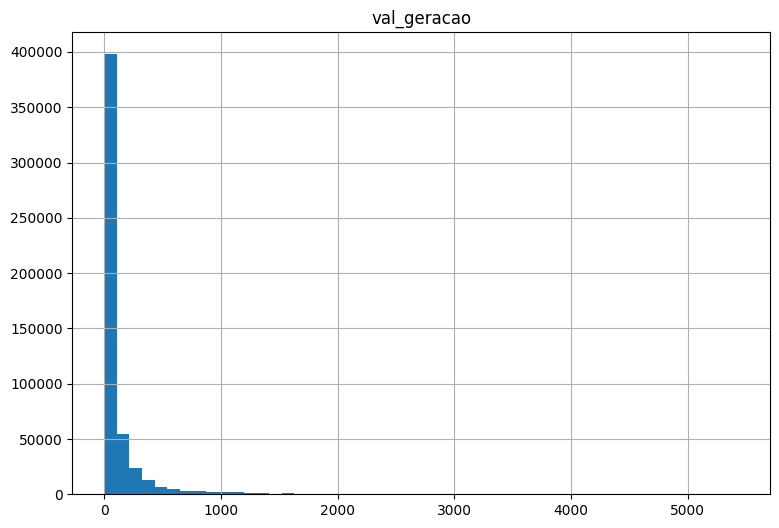

In [8]:
# Histograma
df_consolidado.hist(figsize = (9,6), bins=50)
plt.show()

O histograma mostra que, de fato, a grande maioria dos registros possui valor de geração de até 100 MW.

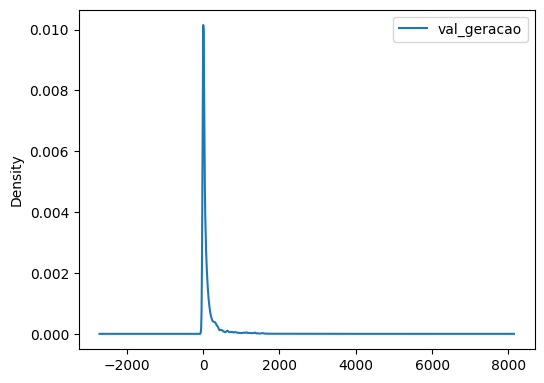

In [9]:
# Density Plot
df_consolidado.plot(kind = 'density', subplots = True, layout = (3,3), sharex = False, figsize = (20,15))
plt.show()

O Density Plot mostra a mesma informação do histograma, apenas de uma forma diferente de visualização.

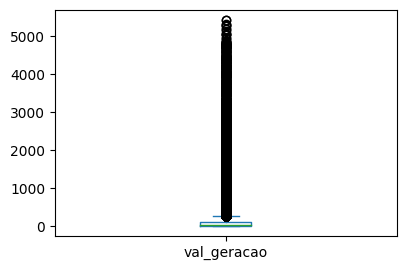

In [10]:
# Boxplot
df_consolidado.plot(kind = 'box', subplots = True, layout = (3,3), sharex = False, sharey = False, figsize = (15,10))
plt.show()

O boxplot também mostra que a maior parte dos valores está abaixo dos 100 MW, porém há um grande número de outliers com valores bem superiores. Isso não representa um problema nos dados, apenas reflete as características das usinas que compõem o sistema.

De forma a visualizar melhor as características de cada tipo de usina, por fonte, a seguir foi criado um gráfico boxplot para cada categoria.

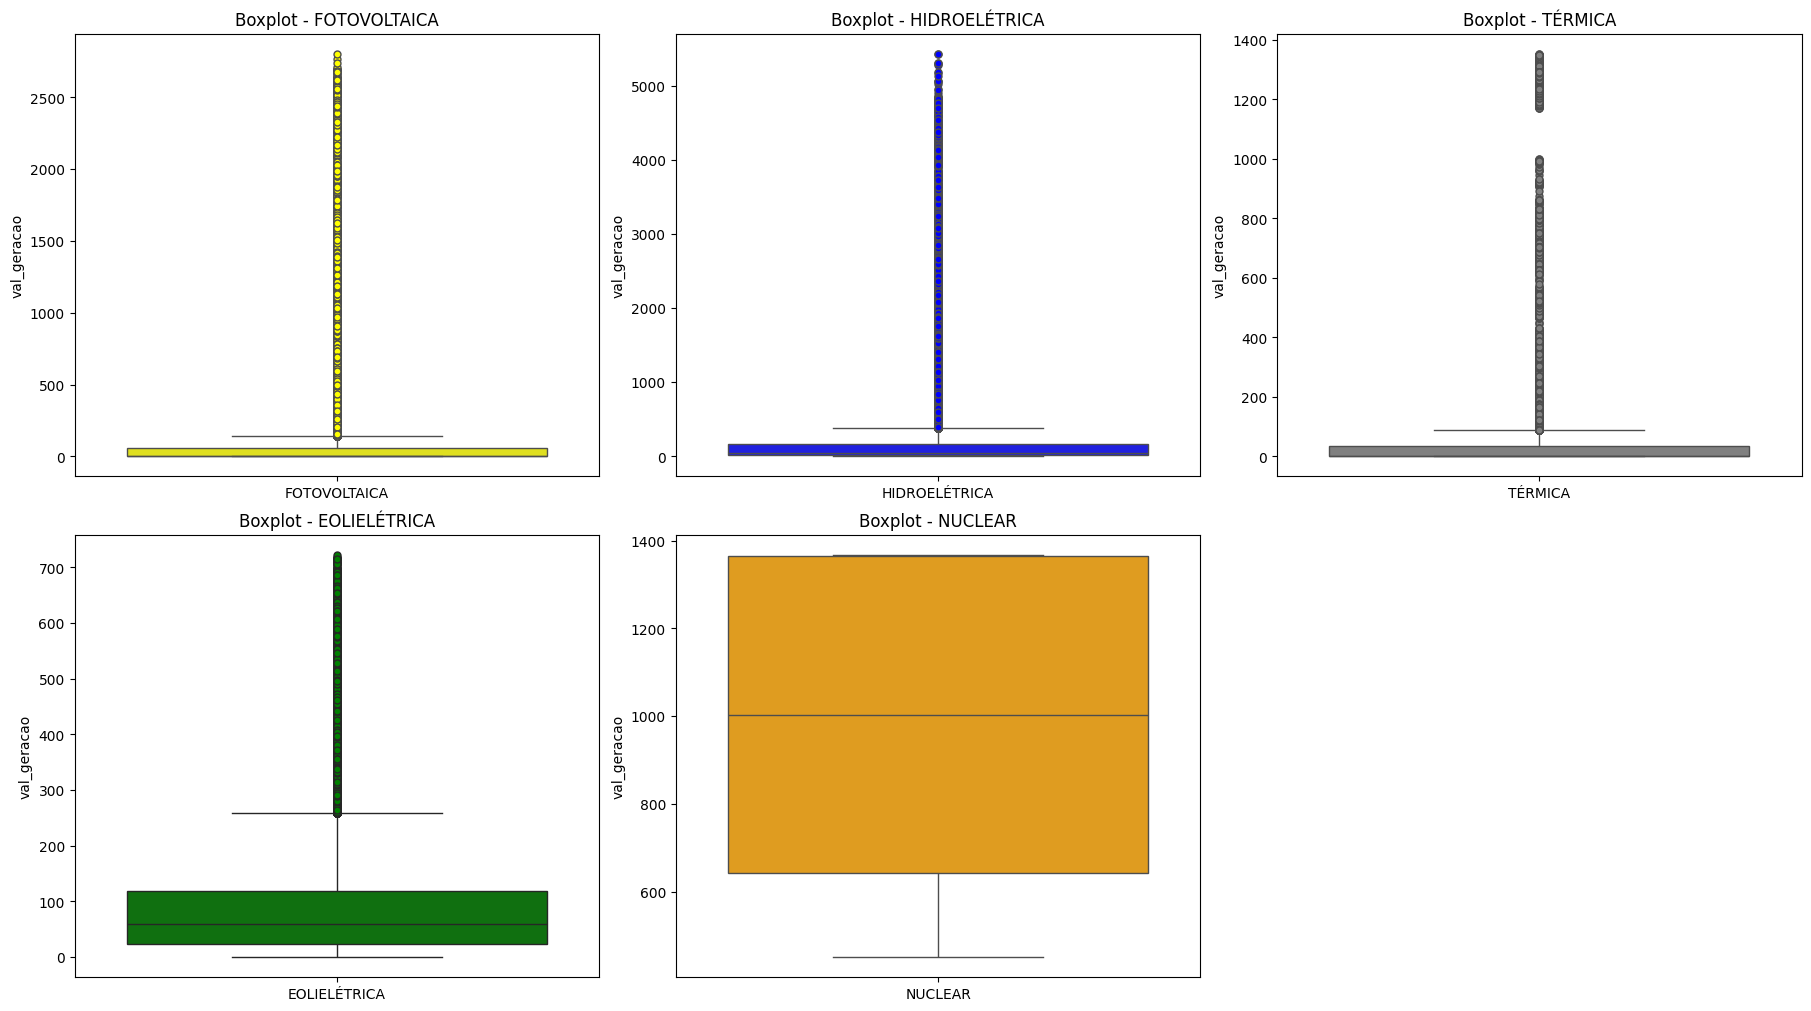

In [11]:
# Definir as cores para cada tipo de usina
cores_usinas = {
    'EOLIELÉTRICA': 'green',
    'FOTOVOLTAICA': 'yellow',
    'HIDROELÉTRICA': 'blue',
    'NUCLEAR': 'orange',
    'TÉRMICA': 'gray'
}

# Colocar os nomes dos tipos de usinas em maiúsculas, caso ainda não estejam
df_consolidado['nom_tipousina'] = df_consolidado['nom_tipousina'].str.upper()

# Criar subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10), constrained_layout=True)

# Listar os tipos de usinas
tipos_usina = df_consolidado['nom_tipousina'].unique()

# Loop para criar um boxplot separado para cada tipo de usina
for i, tipo in enumerate(tipos_usina):
    ax = axes[i // 3, i % 3]  # Define a posição do subplot (2 linhas, 3 colunas)

    # Filtrar os dados para o tipo de usina
    df_filtrado = df_consolidado[df_consolidado['nom_tipousina'] == tipo]

    # Definir a aparência dos outliers (flierprops), com a mesma cor do boxplot
    flierprops = dict(marker='o', markerfacecolor=cores_usinas[tipo], markersize=5, linestyle='none')

    # Criar o boxplot para o tipo de usina com a cor correspondente e outliers coloridos
    sns.boxplot(x='nom_tipousina', y='val_geracao', data=df_filtrado, ax=ax, color=cores_usinas[tipo], flierprops=flierprops)

    # Definir o título do gráfico
    ax.set_title(f'Boxplot - {tipo}')

    # Remover o rótulo do eixo x (não é necessário repetir o nome da usina)
    ax.set_xlabel('')

# Remover o subplot vazio se houver menos de 6 gráficos
if len(tipos_usina) < 6:
    fig.delaxes(axes[1, 2])

# Exibir os gráficos
plt.show()


Nestes gráficos boxplot, é importante destacar que cada subplot possui uma escala diferente. Isto foi feito propositalmente para melhor visualizar os dados de cada fonte, porém é necessário levar isso em conta ao analisar os gráficos.

Também cabe ressaltar que foi adotado um padrão de cores para representar cada fonte de geração:
Solar fotovoltaica: amarelo;
Hidroelétrica: azul;
Eólica: verde;
Térmica: cinza;
Nuclear: laranja.
Esse padrão de cores será mantido em todos os demais gráficos.

Percebe-se que, mesmo separando por tipo de usina, a maioria dos casos apresenta um grande número de outliers, devido a presença de algumas usinas de maior porte. A exceção é a fonte Nuclear, que possui apenas duas usinas (640 e 1350 MW), logo os registros de geração ficam limitados a esta faixa de valores.

Como o dataset possui apenas um atributo numérico, não foram criados gráficos de correlação.

Com os dados já avaliados, foi realizada a etapa de pré-processamento dos dados.

**4. Pré-processamento de Dados**

**4.1. Tratamento de Missings e Limpeza**

In [12]:
# verificando nulls no dataset
df_consolidado.isnull().sum()

,0
din_instante,0
id_subsistema,0
nom_subsistema,0
id_estado,0
nom_estado,0
cod_modalidadeoperacao,0
nom_tipousina,0
nom_tipocombustivel,0
nom_usina,0
id_ons,0


Verificou-se que há 1488 linhas em que o atributo "val_geracao" está vazio. É possível que estes registros sejam referentes a usinas que realmente não geraram energia naquela hora, porém também podem haver dados faltantes. De qualquer forma, estas 1488 linhas representam menos de 0,3% do total de 519408 linhas do dataset. Assim, optou-se por excluir estas linhas. Também foram excluídas algumas colunas que não são relevantes para o problema.

Nos demais atributos, não foram identificados valores nulos.

<Axes: >

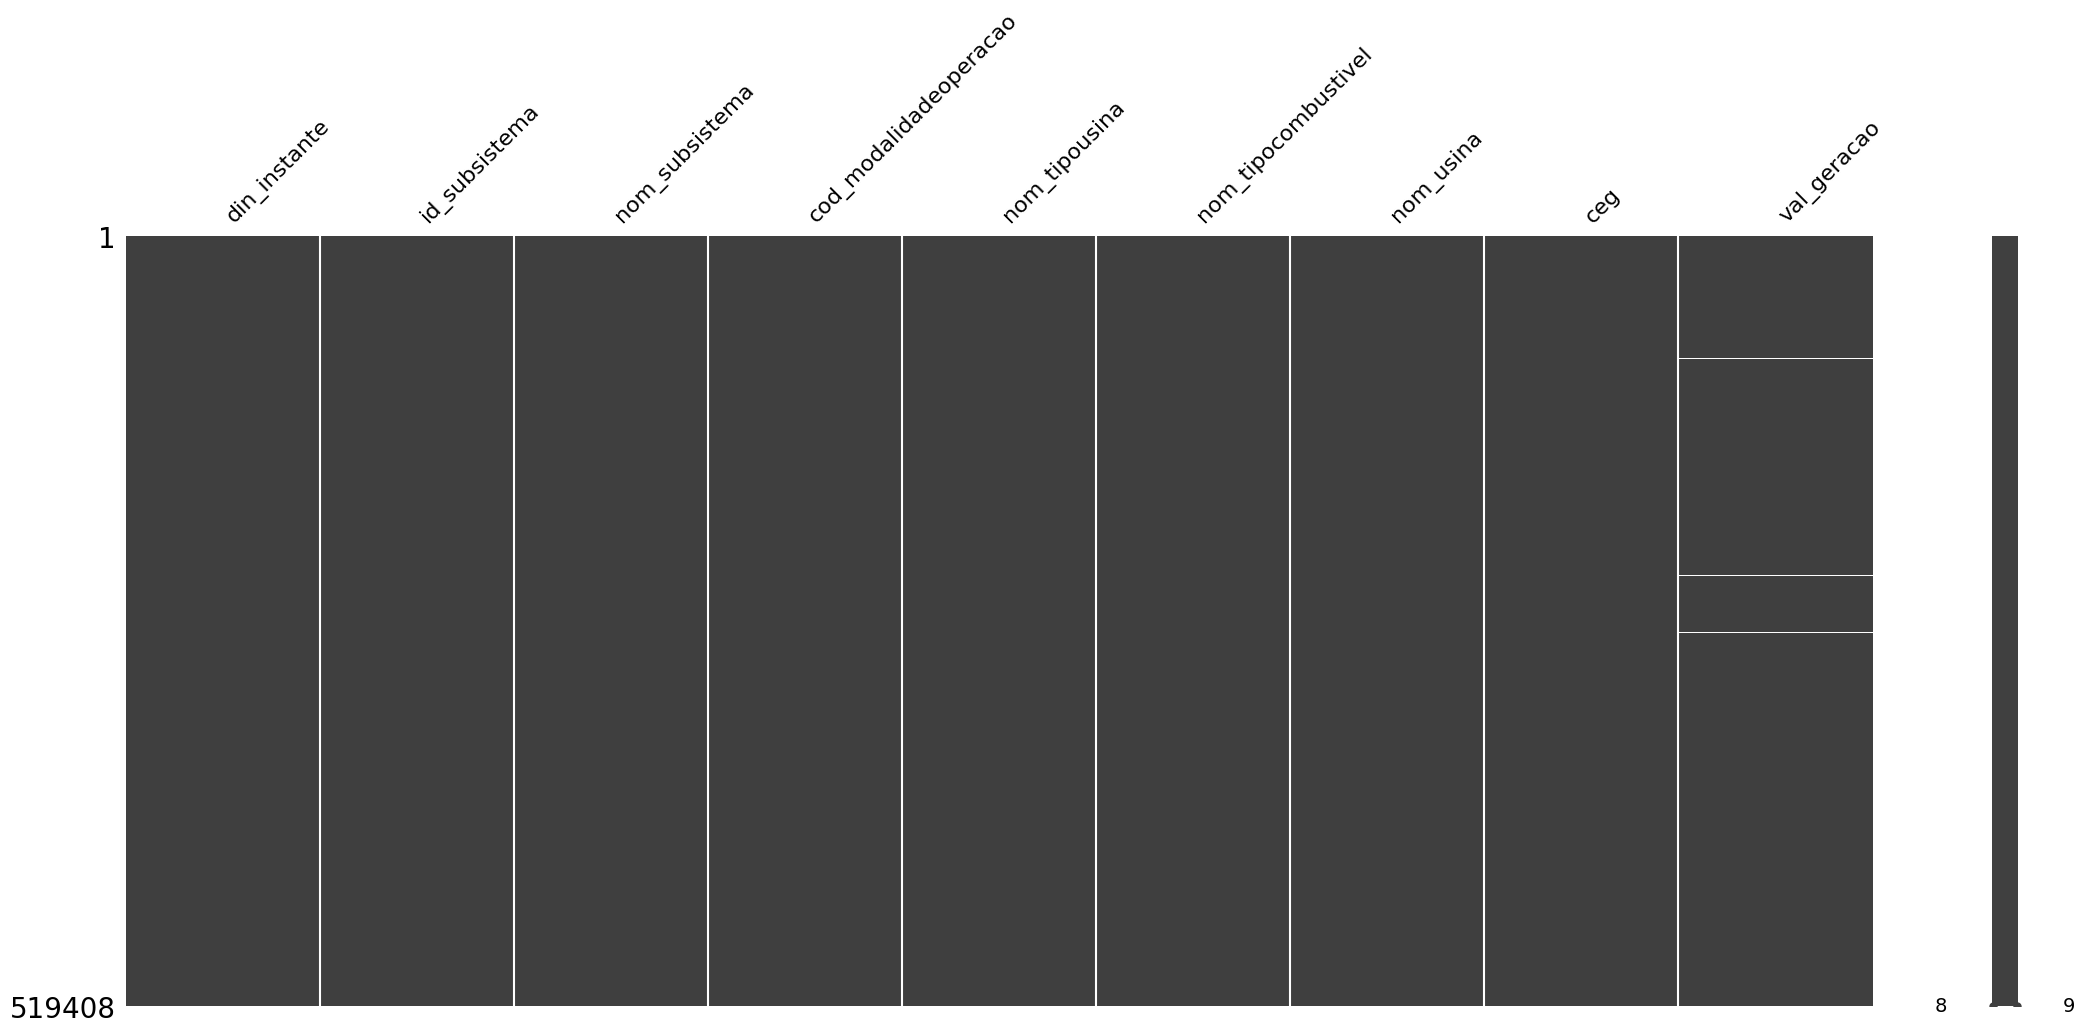

In [13]:
# Recuperando os nomes das colunas
col = list(df_consolidado.columns)

# Criando um novo dataset sem as colunas que não são relevantes
datasetSemMissings = df_consolidado.drop(['id_estado', 'nom_estado', 'id_ons'], axis=1)

# Exibindo a visualização da nulidade do dataset
msno.matrix(datasetSemMissings)


<Axes: >

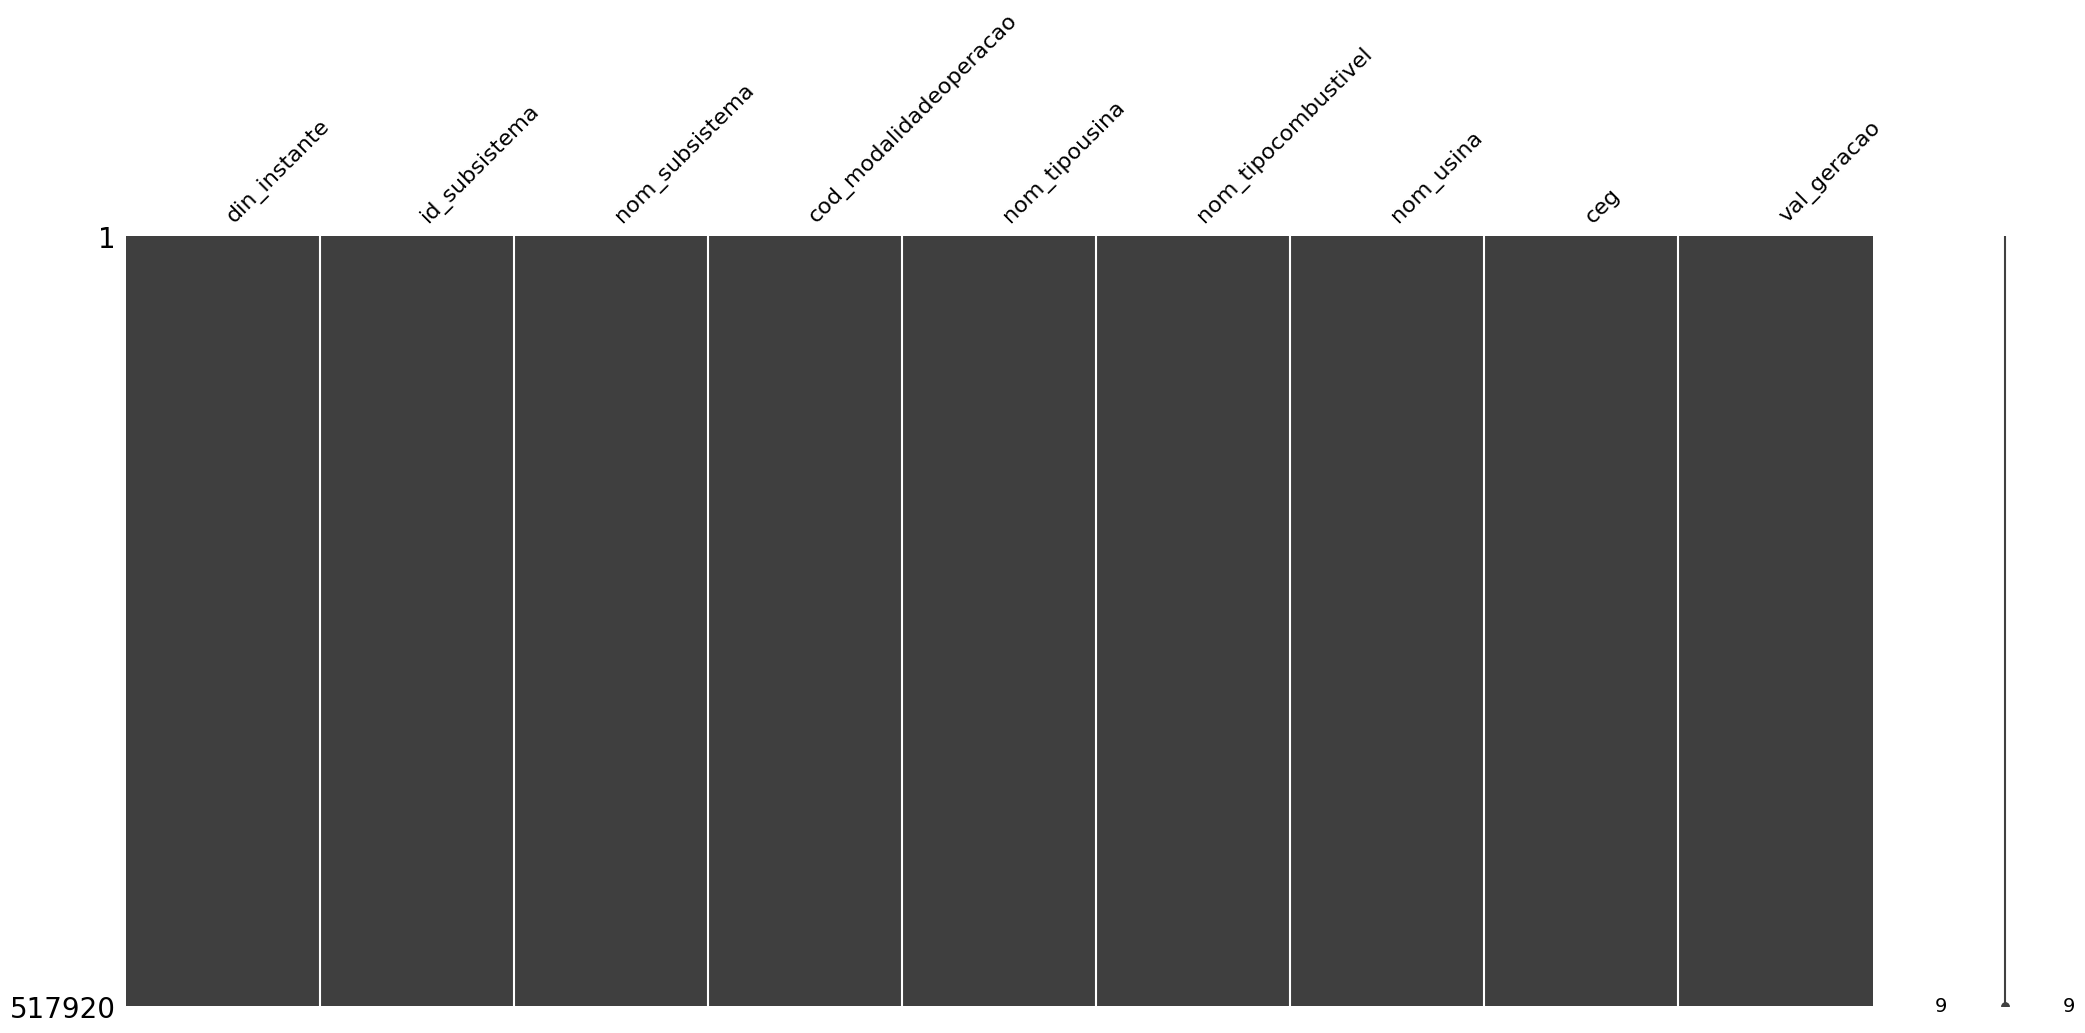

In [14]:
# Excluindo as linhas onde houver qualquer valor nulo
datasetSemMissings.dropna(inplace=True)

# Exibindo a visualização da nulidade do dataset após a remoção dos nulos
msno.matrix(datasetSemMissings)

Também foi realizada a conversão da coluna din_instante para o formato adequado:

In [15]:
datasetSemMissings['din_instante'] = pd.to_datetime(datasetSemMissings['din_instante'])


Como o objetivo da análise envolve apenas a geração por tipo de usina, e não a geração individualizada de cada usina, foi criado um dataframe agregando os dados de geração por tipo de usina, mantendo a segregação por data e hora. Este dataframe será utilizado para a geração de gráficos e realização de algumas análises.

In [16]:
# Agrupando por 'nom_tipousina' e 'din_instante' e somando a coluna 'val_geracao'
df_fonte = datasetSemMissings.groupby(['nom_tipousina', 'din_instante'])['val_geracao'].sum().reset_index()

# Exibir as primeiras linhas do novo DataFrame
print(df_fonte.head())


  nom_tipousina        din_instante  val_geracao
0  EOLIELÉTRICA 2024-08-01 00:00:00    19959.366
1  EOLIELÉTRICA 2024-08-01 01:00:00    20305.697
2  EOLIELÉTRICA 2024-08-01 02:00:00    19754.744
3  EOLIELÉTRICA 2024-08-01 03:00:00    19373.712
4  EOLIELÉTRICA 2024-08-01 04:00:00    19879.288


Como pode ser visto nas primeiras linhas do novo dataset, temos agora, para cada tipo de usina, a geração total em cada hora.

Inicialmente, foi gerado um gráfico de colunas empilhadas, mostrando a geração de energia em todo o histórico do dataset, que neste exemplo ficou limitado ao mês de agosto de 2024.

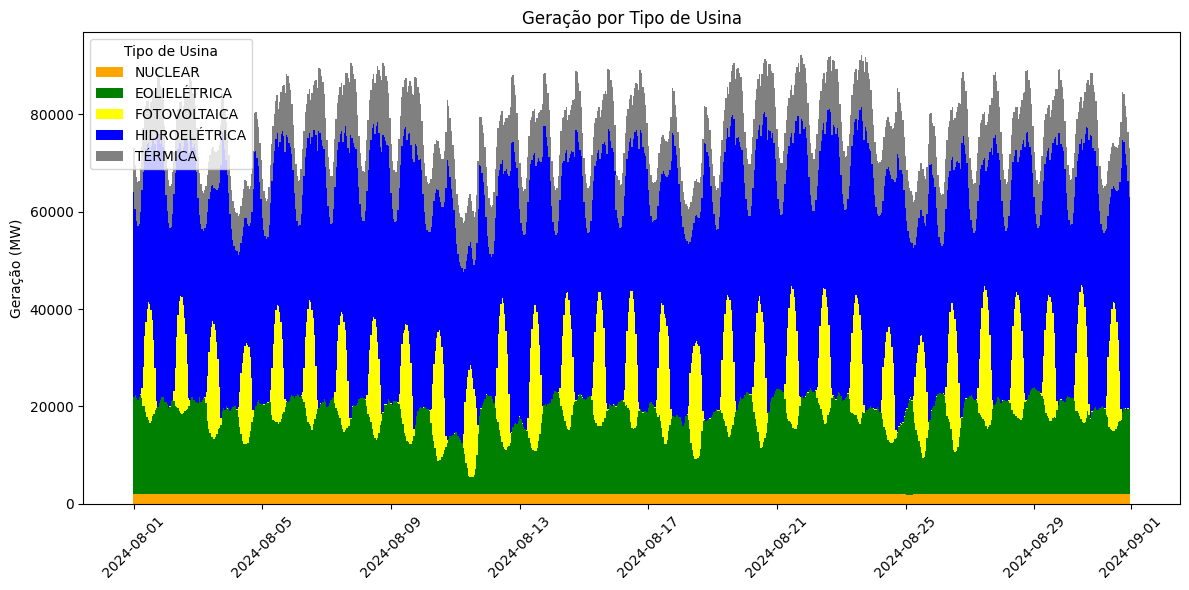

In [21]:
# Definir as cores para cada tipo de usina
cores_usinas = {
    'NUCLEAR': 'orange',
    'EOLIELÉTRICA': 'green',
    'FOTOVOLTAICA': 'yellow',
    'HIDROELÉTRICA': 'blue',
    'TÉRMICA': 'gray'
}

# Definir a ordem dos tipos de usina
ordem_tipos_usinas = ['NUCLEAR', 'EOLIELÉTRICA', 'FOTOVOLTAICA', 'HIDROELÉTRICA', 'TÉRMICA']

# Definir o tamanho da figura
plt.figure(figsize=(12,6))

# Criar uma lista de instantes únicos
instantes = df_fonte['din_instante'].unique()

# Criar uma base inicial de zeros para as barras empilhadas
base = np.zeros(len(instantes))

# Definir a largura das colunas
largura_colunas = 0.05

# Loop pelos tipos de usinas na ordem definida
for tipo in ordem_tipos_usinas:
    df_filtrado = df_fonte[df_fonte['nom_tipousina'] == tipo]

    # Garantir que os dados estejam no mesmo tamanho de 'instantes'
    valores_filtrados = [df_filtrado[df_filtrado['din_instante'] == instante]['val_geracao'].sum() if instante in df_filtrado['din_instante'].values else 0 for instante in instantes]

    # Criar as barras empilhadas com cores definidas
    plt.bar(instantes, valores_filtrados, width=largura_colunas, bottom=base, label=tipo, color=cores_usinas[tipo])

    # Atualizar a base (acumular as alturas das barras já plotadas)
    base += valores_filtrados

# Rótulos e título
plt.ylabel('Geração (MW)')
plt.title('Geração por Tipo de Usina')

# Definir os rótulos no eixo x e rotacionar
plt.xticks(rotation=45)

# Exibir a legenda
plt.legend(title='Tipo de Usina')

# Ajustar o layout e exibir o gráfico
plt.tight_layout()
plt.show()


Analisando o gráfico acima, podemos fazer algumas observações:
- O total de energia gerada (soma de todas as fontes) possui um comportamento típico, com valores mais elevados em algumas horas do dia e menores durante a noite. Também há variação em relação aos dias da semana, com menor geração nos finais de semana. Esse comportamento reflete o perfil de consumo de energia no país.
- A fonte Nuclear possui uma geração constante, compatível com as características técnicas deste tipo de usina.
- A fonte eólica, que não é controlável (gera sempre que estiver ventando), oscila bastante, com aparente maior geração durante a noite.
- A fonte solar fotovoltaica, como era esperado, gera apenas durante o dia.
- As fontes hidroelétrica e térmica, que são comandadas pelo Operador Nacional do Sistema (ONS), são usadas para compensar a variação das fontes eólica e solar. Entretanto, esse efeito não fica tão claro no gráfico de colunas empilhadas. Por isso, foi criado um subplot com um gráfico para cada fonte.

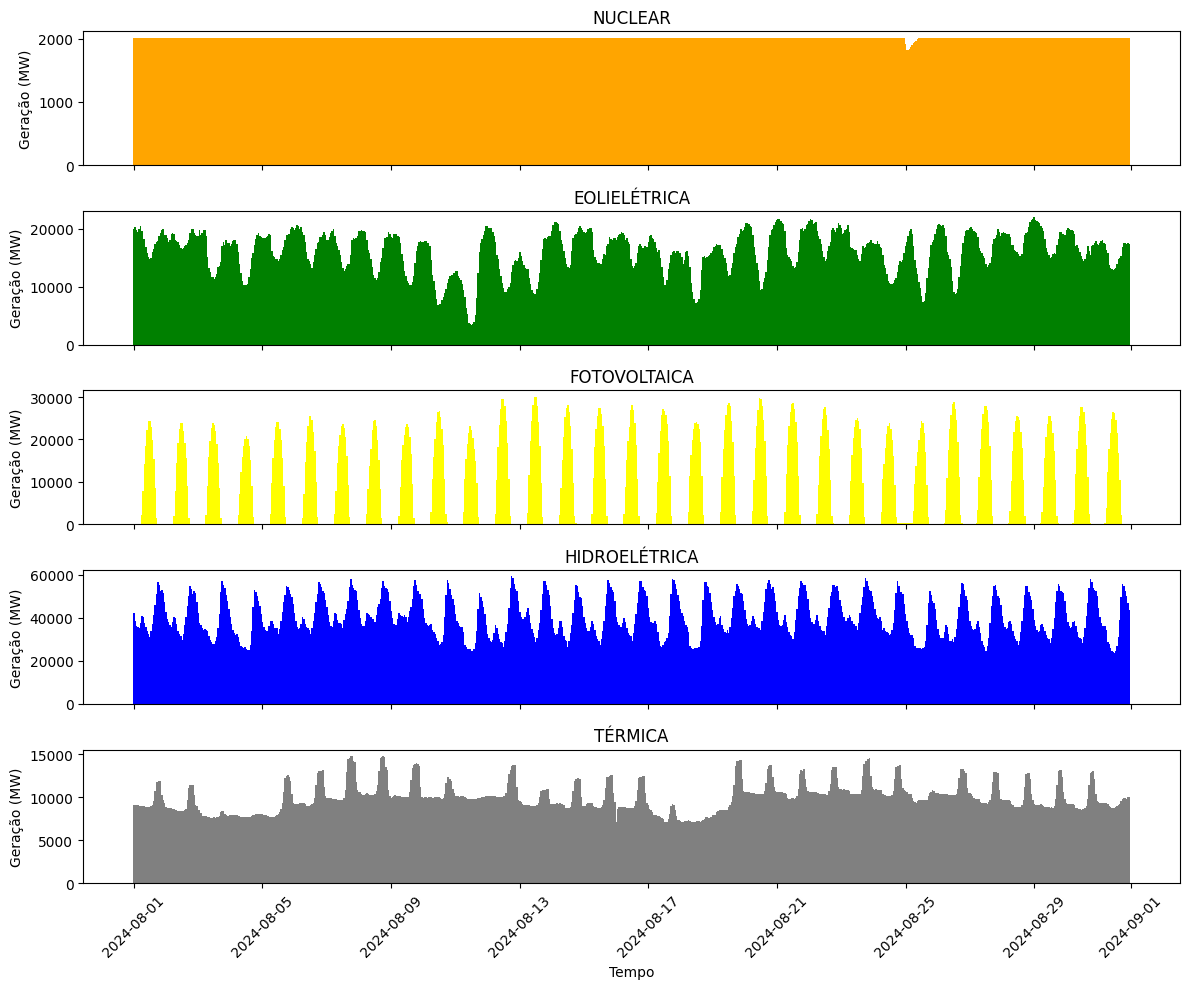

In [23]:
# Definir as cores para cada tipo de usina
cores_usinas = {
    'NUCLEAR': 'orange',
    'EOLIELÉTRICA': 'green',
    'FOTOVOLTAICA': 'yellow',
    'HIDROELÉTRICA': 'blue',
    'TÉRMICA': 'gray'
}

# Definir a ordem dos tipos de usina
ordem_tipos_usinas = ['NUCLEAR', 'EOLIELÉTRICA', 'FOTOVOLTAICA', 'HIDROELÉTRICA', 'TÉRMICA']

# Criar uma lista de instantes únicos
instantes = df_fonte['din_instante'].unique()

# Definir o tamanho da figura e a disposição dos subplots (5 linhas e 1 coluna)
fig, axes = plt.subplots(5, 1, figsize=(12, 10))  # 5 gráficos, um abaixo do outro

# Loop pelos tipos de usina na ordem definida
for i, tipo in enumerate(ordem_tipos_usinas):
    df_filtrado = df_fonte[df_fonte['nom_tipousina'] == tipo]

    # Garantir que os dados estejam no mesmo tamanho de 'instantes'
    valores_filtrados = [df_filtrado[df_filtrado['din_instante'] == instante]['val_geracao'].sum() if instante in df_filtrado['din_instante'].values else 0 for instante in instantes]

    # Criar as barras no subplot correspondente
    axes[i].bar(instantes, valores_filtrados, color=cores_usinas[tipo], width=0.05)

    # Adicionar título e rótulo ao eixo y
    axes[i].set_title(f'{tipo}')
    axes[i].set_ylabel('Geração (MW)')

    # Desabilitar os rótulos do eixo x para todos os gráficos, exceto o último
    if i < len(ordem_tipos_usinas) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        # Apenas o último gráfico terá rótulos e ticks no eixo x
        axes[i].set_xlabel('Tempo')
        axes[i].tick_params(axis='x', rotation=45)

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Exibir os gráficos
plt.show()


Nos gráficos acima é possível ver com maior detalhe o perfil de operação de cada tipo de usina, ficando mais claro que as hidroelétricas e as térmicas aumentam a geração para compensar a redução da geração solar no final da tarde/início da noite. Importante destacar novamente que cada gráfico possui uma escala diferente, e isso deve ser levado em conta no momento de analisar os gráficos.

De forma a visualizar melhor e confirmar esta percepção, foi criado a seguir um gráfico com a geração média horária de cada tipo de usina.

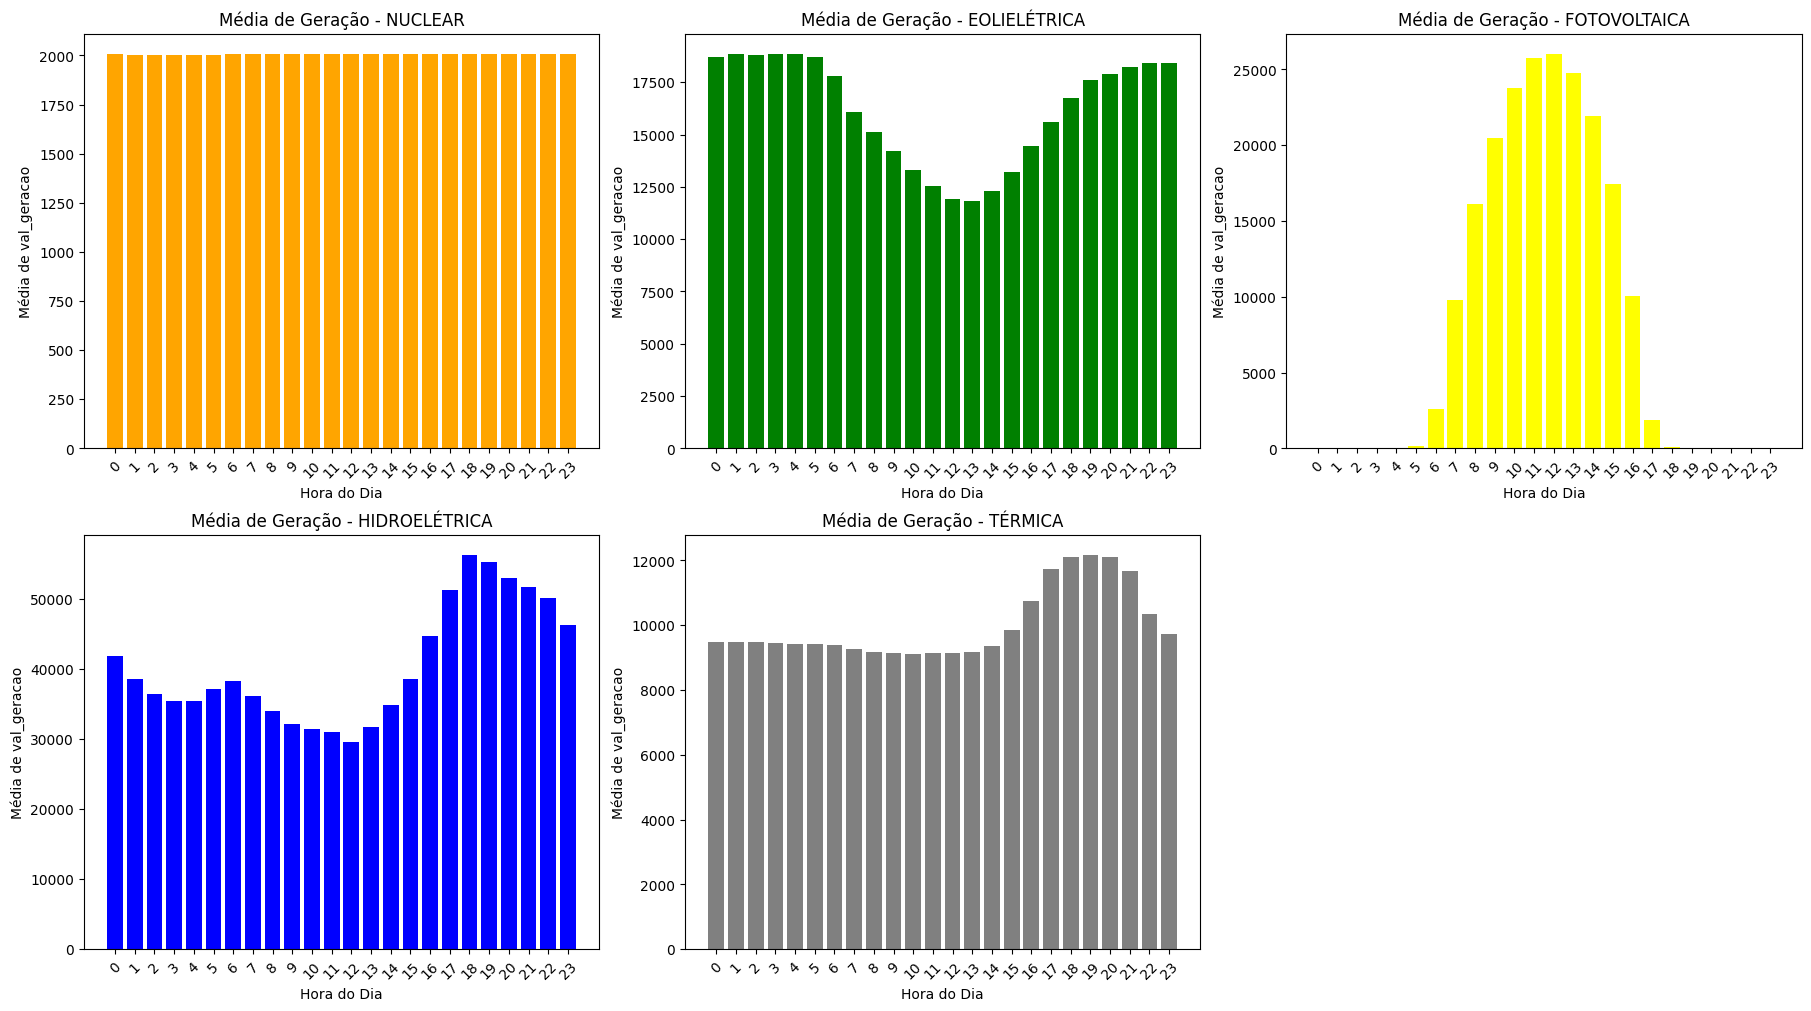

In [19]:
# Definir os tipos de usinas e as cores correspondentes
cores_usinas = {
    'NUCLEAR': 'orange',
    'EOLIELÉTRICA': 'green',
    'FOTOVOLTAICA': 'yellow',
    'HIDROELÉTRICA': 'blue',
    'TÉRMICA': 'gray'
}

# Criar a figura e subplots (5 gráficos, distribuídos em 2 linhas e 3 colunas)
fig, axes = plt.subplots(2, 3, figsize=(18, 10), constrained_layout=True)

# Extrair a hora de 'din_instante'
df_fonte['hora'] = df_fonte['din_instante'].dt.hour

# Agrupar os dados por 'hora' e 'nom_tipousina' e calcular a média de 'val_geracao'
df_horas = df_fonte.groupby(['hora', 'nom_tipousina'])['val_geracao'].mean().reset_index()

# Plotar cada gráfico em um subplot individual
for i, tipo in enumerate(cores_usinas.keys()):
    # Determinar a posição do subplot (2 linhas, 3 colunas)
    ax = axes[i // 3, i % 3]

    # Filtrar os dados para o tipo de usina
    df_filtrado = df_horas[df_horas['nom_tipousina'] == tipo]

    # Garantir que os dados estejam no mesmo tamanho de 'horas'
    horas = df_filtrado['hora']
    valores_filtrados = df_filtrado['val_geracao']

    # Plotar o gráfico de barras para essa fonte específica com a cor personalizada
    ax.bar(horas, valores_filtrados, color=cores_usinas[tipo])

    # Configurar rótulos e título
    ax.set_title(f'Média de Geração - {tipo}')
    ax.set_xlabel('Hora do Dia')
    ax.set_ylabel('Média de val_geracao')
    ax.set_xticks(np.arange(0, 24, step=1))
    ax.set_xticklabels(np.arange(0, 24, step=1), rotation=45)

# Remover o gráfico vazio (caso haja menos de 6 gráficos)
if len(cores_usinas) < 6:
    fig.delaxes(axes[1, 2])

# Exibir os gráficos
plt.show()



Os gráficos acima mostram o perfil típico de cada fonte de geração:
- Nuclear: constante;
- Eólica: geração varia durante o dia de acordo com os ventos, geração mais elevada durante a noite;
- Solar fotovoltaica: geração conforme o sol, com pico de geração em torno do meio dia;
- Hidroelétrica: geração aumenta no final da tarde para compensar a redução da geração solar;
- Térmica: da mesma forma que a hidroelétrica, geração térmica aumenta no final da tarde para compensar a redução da geração solar.

Por fim, foi criado um gráfico de colunas empilhadas consolidando a geração média horária de cada fonte.

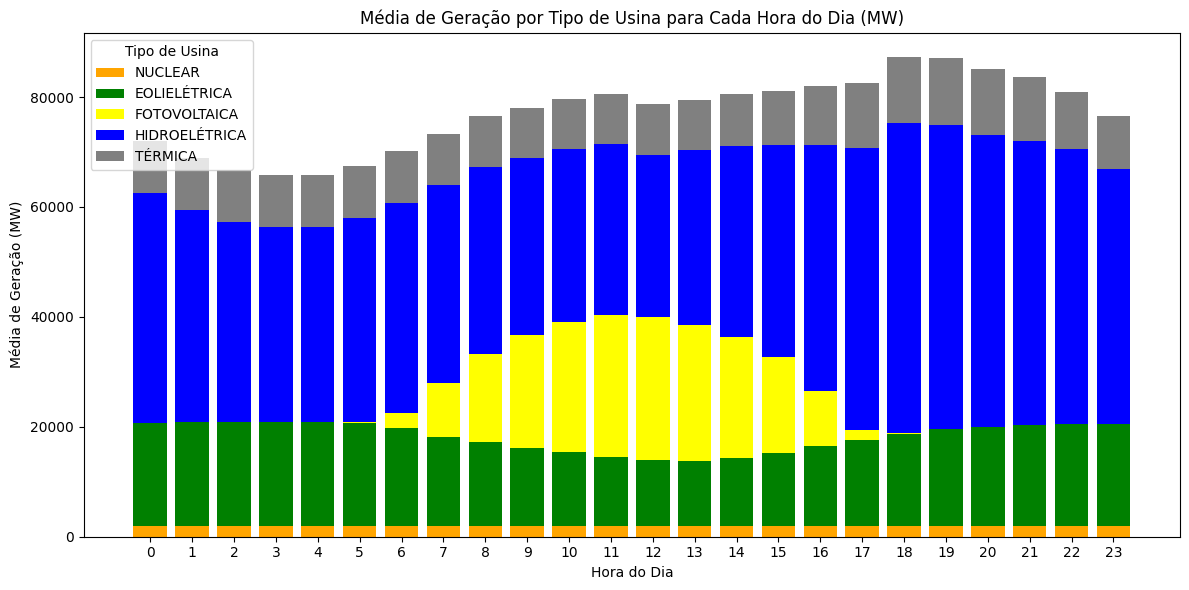

In [24]:
# Definir as cores para cada tipo de usina em letras maiúsculas
cores_usinas = {
    'NUCLEAR': 'orange',
    'EOLIELÉTRICA': 'green',
    'FOTOVOLTAICA': 'yellow',
    'HIDROELÉTRICA': 'blue',
    'TÉRMICA': 'gray'
}

# Extrair a hora de 'din_instante'
df_fonte['hora'] = df_fonte['din_instante'].dt.hour

# Agrupar os dados por 'hora' e 'nom_tipousina' e calcular a média de 'val_geracao'
df_fonte['nom_tipousina'] = df_fonte['nom_tipousina'].str.upper()  # Colocando em maiúsculas
df_horas = df_fonte.groupby(['hora', 'nom_tipousina'])['val_geracao'].mean().reset_index()

# Criar uma lista de horas únicas
horas = df_horas['hora'].unique()

# Criar uma base inicial de zeros para as barras empilhadas
base = np.zeros(len(horas))

# Definir o tamanho da figura
plt.figure(figsize=(12, 6))

# Para cada tipo de usina, criamos um gráfico de barras empilhadas com as cores personalizadas
for tipo in cores_usinas.keys():
    # Filtrar os dados para o tipo de usina
    df_filtrado = df_horas[df_horas['nom_tipousina'] == tipo]

    # Garantir que os dados estejam no mesmo tamanho de 'horas'
    valores_filtrados = [df_filtrado[df_filtrado['hora'] == hora]['val_geracao'].values[0] if hora in df_filtrado['hora'].values else 0 for hora in horas]

    # Criar as barras empilhadas com a cor correspondente
    plt.bar(horas, valores_filtrados, bottom=base, color=cores_usinas[tipo], label=tipo)

    # Atualizar a base (acumular as alturas das barras já plotadas)
    base += valores_filtrados

# Rótulos e título
plt.xlabel('Hora do Dia')
plt.ylabel('Média de Geração (MW)')
plt.title('Média de Geração por Tipo de Usina para Cada Hora do Dia (MW)')

# Definir os rótulos no eixo x e rotacionar, se necessário
plt.xticks(np.arange(0, 24, step=1))

# Exibir a legenda
plt.legend(title='Tipo de Usina')

# Ajustar o layout e exibir o gráfico
plt.tight_layout()
plt.show()


Em resumo, entendo que o objetivo do trabalho foi plenamente alcançado. Foram realizadas as etapas de análise e pré-processamento dos dados, usando os conceitos estudados nesta disciplina. Foi possível obter um bom entendimento dos dados sobre a geração de energia elétrica por tipo de usina. Além disso, as ferramentas e conceitos aplicados neste
projeto podem ser facilmente replicados em outros conjuntos de dados, em diversas situações práticas.